# Gradient Boosting Notebook

This notebook illustrates the use of the gradient boosting ensemble classifier. We show that this classifier can have improved properties over using a single classifier and bagging. The individual predictors are regression stumps (trees of depth equal to 1 that predict a real value). We will evaluate the performance of this classifier on the Breast Cancer dataset and compare it with a single classification tree and a bagging ensemble of classification trees. 

First, we import the required packages. These will be the standard ones, including autograd to compute gradients. 

In [1]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
import copy

## Loading the data

We load the data from a CSV file using pandas. The dataset considered is 'Wisconsin Diagnostic Breast Cancer' from the UCI repository. We ignore the first attribute in this dataset, which corresponds to the ID of each sample. The task of interest is to predict whether or not a cell corresponds to a malignant tumor. In this dataset all attributes take real values. These include area, smoothness, perimeter, etc.

In [2]:
data = pd.read_csv('wdbc.csv')
X = data.values[ :, 2:].astype(float)
y = (data.values[ :, 1 ] == 'B').astype(int)

## Performance Evaluation


We evaluate the performance of the bagging classifier on this dataset as a function of the ensemble size, and compare results with a single classification tree. We make extensive use of the pipeline framework of scikit-learn.

### Defining the Pipeline of Data Transformation and Estimation

We create a Pipeline for training the classifier in the cross validation procedure used to evaluate the performance. The ensemble size is set to 101, an odd number used to avoid ties in the voting process used to make predictions. This pipeline should include a standardization process too. This is omitted here since we will be working with  trees in which the standardization process has no effect. We create another pipeline for the classification tree and for bagging. The max_depth of the trees is set to one (trees with only one splitting node) and the learning rate $\nu$ parameter is set equal to $0.5$. Tuning this parameter is expensive using corss-validation since it involves building several ensembles, so this step is not considered here.

In [3]:
ensemble_size = 101

# First random forest ensemble We will use the default parameter value to
# select how many random attributes will be tested for creating a split at each node

pipeline_gb = Pipeline([ ('gb', GradientBoostingClassifier(max_depth = 1, \
        n_estimators = ensemble_size, learning_rate = 0.5)) ])

# Next bagging

pipeline_bag = Pipeline([ ('bag', BaggingClassifier(estimator = \
    DecisionTreeClassifier(), n_estimators = ensemble_size)) ])

# In the single tree we use max-depth=4 since this gave good results previusly

pipeline_tree = Pipeline([ ('tree', DecisionTreeClassifier(max_depth = 4)) ])

### Defining the Data Splits and the Arrays to Store the Results

We create an object used to split the data and validate the performance of the pipeline created before. We also create arrays to store the test error of each method: the bagging ensemble and the single classification tree. We will average results 10 times (10 times 10-fold-stratified-cv) to reduce the variance of the results.

In [4]:
rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)

# We will store here the results

accuracies_gb = np.zeros((100, ensemble_size))
accuracies_gb_train = np.zeros((100, ensemble_size))
accuracies_bag = np.zeros((100, ensemble_size))
accuracies_tree = np.zeros(100)

### Evaluating the Performance for each data split

We use stratified 10 fold cross-validation, to estimate the performance of the classifier. We use prediction accuracy as the evaluation metric. Other metrics can be considered as well. We will consider 10 splits of the data, corresponding to 10-fold-cv. This will be repeated 10 times, resulting in 100 folds.

In [5]:
split = 0

# We loop over the data partitions

for train_index, test_index in rkf.split(X, y):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    pipeline_bag.fit(X_train, y_train)
    pipeline_gb.fit(X_train, y_train)
    
    # We evaluate the performance for each ensemble size

    for i in range(ensemble_size, 0, -1):
        pipeline_bag.set_params(bag__n_estimators=i)
        pipeline_gb.set_params(gb__n_estimators=i)
        pipeline_gb.steps[0][1].estimators_ =  pipeline_gb.steps[0][1].estimators_[ 0 : i ]

        accuracies_bag[ split, i - 1 ] = np.mean(pipeline_bag.predict(X_test) == y_test)
        accuracies_gb[ split, i - 1 ] = np.mean(pipeline_gb.predict(X_test) == y_test)
        accuracies_gb_train[ split, i - 1 ] = np.mean(pipeline_gb.predict(X_train) == y_train)

 
    pipeline_gb.set_params(gb__n_estimators=ensemble_size)
    pipeline_bag.set_params(bag__n_estimators=ensemble_size)
    
    # We evaluate the performance of the single tree
    
    pipeline_tree.fit(X_train, y_train)
    accuracies_tree[ split] = np.mean(pipeline_tree.predict(X_test) == y_test)

    split += 1

    print(split)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


### Obtaining the Average Results


We compute average error results alongside with the corresponding standard deviation estimates.

In [6]:
mean_errors_gb = np.mean(1.0 - accuracies_gb, 0)
std_mean_errors_gb = np.std(accuracies_gb, 0) / np.sqrt(100)

mean_errors_gb_train = np.mean(1.0 - accuracies_gb_train, 0)
std_mean_errors_gb_train = np.std(accuracies_gb_train, 0) / np.sqrt(100)

mean_errors_bag = np.mean(1.0 - accuracies_bag, 0)
std_mean_errors_bag = np.std(accuracies_bag, 0) / np.sqrt(100)

mean_error_tree = np.mean(1.0 - accuracies_tree)
std_mean_error_tree = np.std(accuracies_tree) / np.sqrt(100)

## Plotting the Results

We plot the average results obtained before. That is, the error of the bagging ensemble as a function of the ensemble size, and the error of a single tree. This error is plotted as an horizontal line.

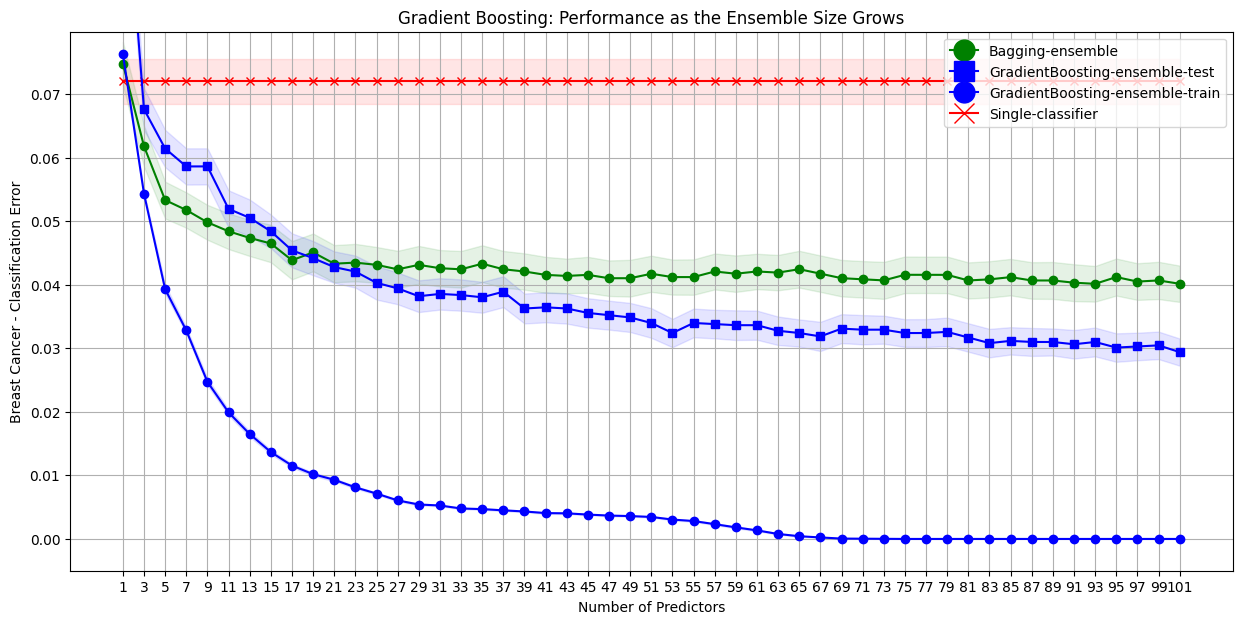

In [7]:
sel = np.arange(1, ensemble_size + 1, 2) - 1
n_estimators = np.arange(1, ensemble_size + 1, 1)

plt.figure(figsize=(15,7))
line1, = plt.plot(n_estimators[ sel ], mean_errors_bag[ sel ], 'o-', color="g")
line2, = plt.plot(n_estimators[ sel ], mean_error_tree * np.ones(len(sel)), 'x-', color="r")
line2, = plt.plot(n_estimators[ sel ], mean_errors_gb[ sel ], 's-', color="b")
line3, = plt.plot(n_estimators[ sel ], mean_errors_gb_train[ sel ], 'o-', color="b")
plt.fill_between(n_estimators[ sel ], (mean_errors_bag - std_mean_errors_bag)[ sel ], \
    (mean_errors_bag + std_mean_errors_bag)[ sel ], alpha=0.1, color="g")
plt.fill_between(n_estimators[ sel ], (mean_errors_gb - std_mean_errors_gb)[ sel ], \
    (mean_errors_gb + std_mean_errors_gb)[ sel ], alpha=0.1, color="b")
plt.fill_between(n_estimators[ sel ], (mean_errors_gb_train - std_mean_errors_gb_train)[ sel ], \
    (mean_errors_gb_train + std_mean_errors_gb_train)[ sel ], alpha=0.1, color="b")
plt.fill_between(n_estimators[ sel ], mean_error_tree * np.ones(len(sel)) \
        + std_mean_error_tree, mean_error_tree * np.ones(len(sel)) - std_mean_error_tree \
        , alpha=0.1, color="r")
plt.grid()
plt.title("Gradient Boosting: Performance as the Ensemble Size Grows")
plt.xlabel('Number of Predictors')
plt.xticks(np.array(n_estimators[ sel ]))
plt.ylabel('Breast Cancer - Classification Error')
plt.ylim((np.min(mean_errors_gb_train[ sel ])) - 0.005, 0.005 + np.max(mean_errors_bag[ sel ]))
legend_handles = [ mlines.Line2D([], [], color='g', marker='o', \
                   markersize=15, label='Bagging-ensemble'),
                   mlines.Line2D([], [], color='b', marker='s', \
                   markersize=15, label='GradientBoosting-ensemble-test'),
                   mlines.Line2D([], [], color='b', marker='o', \
                   markersize=15, label='GradientBoosting-ensemble-train'),
                   mlines.Line2D([], [], color='r', marker='x', \
                   markersize=15, label='Single-classifier') ]
plt.legend(handles=legend_handles, loc = 1)
plt.show()


### Gradient Boosting Over-fitting Problems

In this last section we show one of the problems of Gradient Boosting and boosting techniques in general. They can easily over-fit the training data. For that, we contaminate the previous dataset with some noise in the labels, by randomly flipping 25% of the observed labels, only in the training set. We use again the complete Breast Cancer dataset in these experiments.

In [8]:
split = 0

# We loop over the data partitions

for train_index, test_index in rkf.split(X, y):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # We randomly flit 25% of the labels of the training set
    
    y_train_noisy = y_train.copy()
    sel = np.random.choice(len(y_train_noisy), \
        int(np.round(0.25 * len(y_train_noisy))))
    y_train_noisy[ sel ] = (y_train_noisy[ sel ] + 1) % 1 == 0
    
    pipeline_bag.fit(X_train, y_train_noisy)
    pipeline_gb.fit(X_train, y_train_noisy)
    
    # We evaluate the performance for each ensemble size

    for i in range(ensemble_size, 0, -1):
        pipeline_bag.set_params(bag__n_estimators=i)
        pipeline_gb.set_params(gb__n_estimators=i)
        pipeline_gb.steps[0][1].estimators_ =  pipeline_gb.steps[0][1].estimators_[ 0 : i ]

        accuracies_bag[ split, i - 1 ] = np.mean(pipeline_bag.predict(X_test) == y_test)
        accuracies_gb[ split, i - 1 ] = np.mean(pipeline_gb.predict(X_test) == y_test)
        accuracies_gb_train[ split, i - 1 ] = np.mean(pipeline_gb.predict(X_train) == y_train_noisy)

 
    pipeline_gb.set_params(gb__n_estimators=ensemble_size)
    pipeline_bag.set_params(bag__n_estimators=ensemble_size)
    
    # We evaluate the performance of the single tree
    
    pipeline_tree.fit(X_train, y_train_noisy)
    accuracies_tree[ split] = np.mean(pipeline_tree.predict(X_test) == y_test)

    split += 1

    print(split)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


We compute again average error results alongside with the corresponding standard deviation estimates.

In [9]:
mean_errors_gb = np.mean(1.0 - accuracies_gb, 0)
std_mean_errors_gb = np.std(accuracies_gb, 0) / np.sqrt(100)

mean_errors_gb_train = np.mean(1.0 - accuracies_gb_train, 0)
std_mean_errors_gb_train = np.std(accuracies_gb_train, 0) / np.sqrt(100)

mean_errors_bag = np.mean(1.0 - accuracies_bag, 0)
std_mean_errors_bag = np.std(accuracies_bag, 0) / np.sqrt(100)

mean_error_tree = np.mean(1.0 - accuracies_tree)
std_mean_error_tree = np.std(accuracies_tree) / np.sqrt(100)

We plot the average results obtained before. That is, the error of the bagging ensemble as a function of the ensemble size, and the error of a single tree. This error is plotted as an horizontal line.

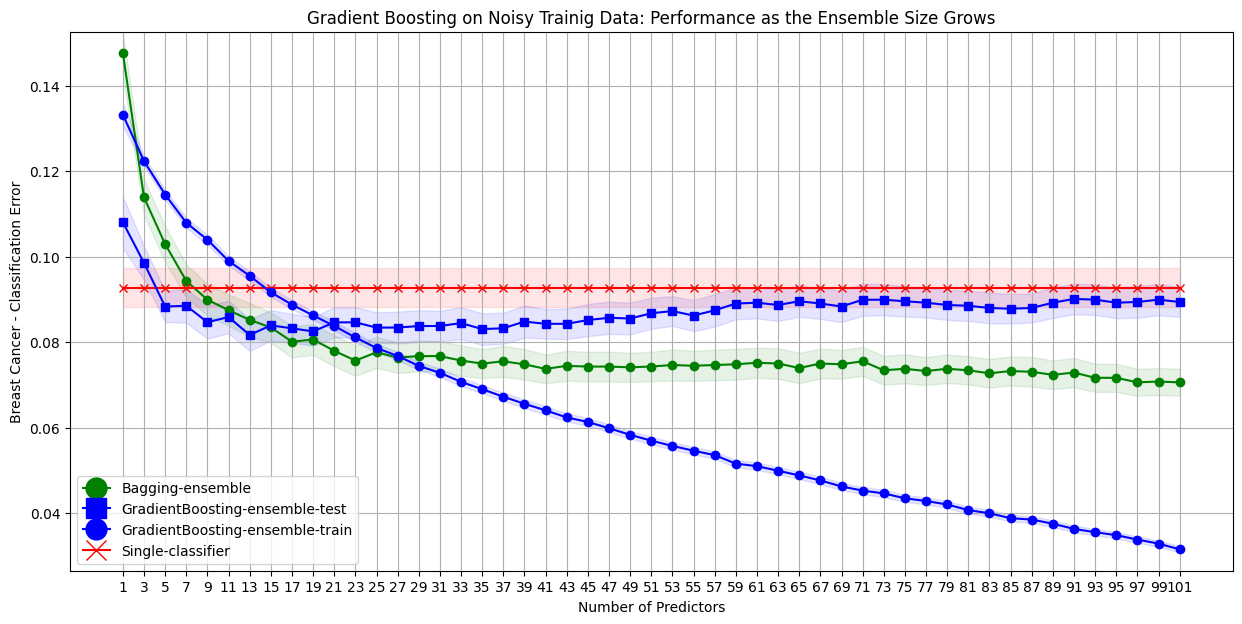

In [10]:
sel = np.arange(1, ensemble_size + 1, 2) - 1
n_estimators = np.arange(1, ensemble_size + 1, 1)

plt.figure(figsize=(15,7))
line1, = plt.plot(n_estimators[ sel ], mean_errors_bag[ sel ], 'o-', color="g")
line2, = plt.plot(n_estimators[ sel ], mean_error_tree * np.ones(len(sel)), 'x-', color="r")
line2, = plt.plot(n_estimators[ sel ], mean_errors_gb[ sel ], 's-', color="b")
line3, = plt.plot(n_estimators[ sel ], mean_errors_gb_train[ sel ], 'o-', color="b")
plt.fill_between(n_estimators[ sel ], (mean_errors_bag - std_mean_errors_bag)[ sel ], \
    (mean_errors_bag + std_mean_errors_bag)[ sel ], alpha=0.1, color="g")
plt.fill_between(n_estimators[ sel ], (mean_errors_gb - std_mean_errors_gb)[ sel ], \
    (mean_errors_gb + std_mean_errors_gb)[ sel ], alpha=0.1, color="b")
plt.fill_between(n_estimators[ sel ], (mean_errors_gb_train - std_mean_errors_gb_train)[ sel ], \
    (mean_errors_gb_train + std_mean_errors_gb_train)[ sel ], alpha=0.1, color="b")
plt.fill_between(n_estimators[ sel ], mean_error_tree * np.ones(len(sel)) \
        + std_mean_error_tree, mean_error_tree * np.ones(len(sel)) - std_mean_error_tree \
        , alpha=0.1, color="r")
plt.grid()
plt.title("Gradient Boosting on Noisy Trainig Data: Performance as the Ensemble Size Grows")
plt.xlabel('Number of Predictors')
plt.xticks(np.array(n_estimators[ sel ]))
plt.ylabel('Breast Cancer - Classification Error')
plt.ylim((np.min(mean_errors_gb_train[ sel ])) - 0.005, 0.005 + np.max(mean_errors_bag[ sel ]))
legend_handles = [ mlines.Line2D([], [], color='g', marker='o', \
                   markersize=15, label='Bagging-ensemble'),
                   mlines.Line2D([], [], color='b', marker='s', \
                   markersize=15, label='GradientBoosting-ensemble-test'),
                   mlines.Line2D([], [], color='b', marker='o', \
                   markersize=15, label='GradientBoosting-ensemble-train'),
                   mlines.Line2D([], [], color='r', marker='x', \
                   markersize=15, label='Single-classifier') ]
plt.legend(handles=legend_handles, loc = 3)
plt.show()


We can observe that again Gradient Boosting reduces the training error to almost zero, but now the test error even increases with the ensemble size. Bagging on the other hand is more robust and does not over-fit the data that much. If we compare this results with Adaboost, gradient boosting is not that effective minimizing the training error because the logistic regression error function penalizes wrong instaces less than the exponential error.

### Classification Frontier Visualization

We show how the decision boundaries of the classifier look like for a single tree and for the bagging ensemble. For simplicity, we only consider the first two attributes of the previous problem. We use all the available data.

In [11]:
X = X[:, [0, 1]]

We plot the data we are going to train the classifier on.

In [12]:
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

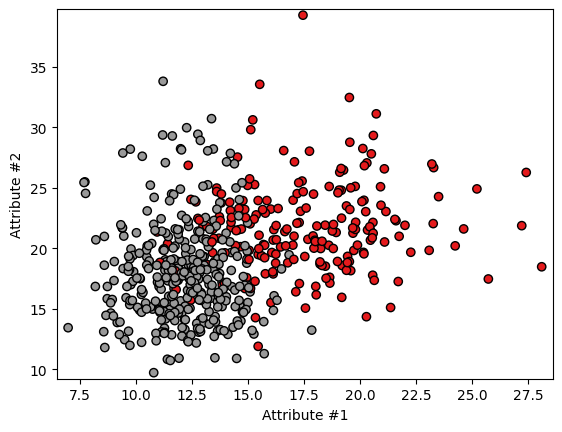

In [13]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, \
    edgecolor='k')
plt.xlabel('Attribute #1')
plt.ylabel('Attribute #2')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

We train the classifiers.

In [14]:
pipeline_bag.fit(X,y)
pipeline_gb.fit(X,y)
pipeline_tree.fit(X,y)

Pipeline(steps=[('tree', DecisionTreeClassifier(max_depth=4))])

We plot the resulting decision boundaries.

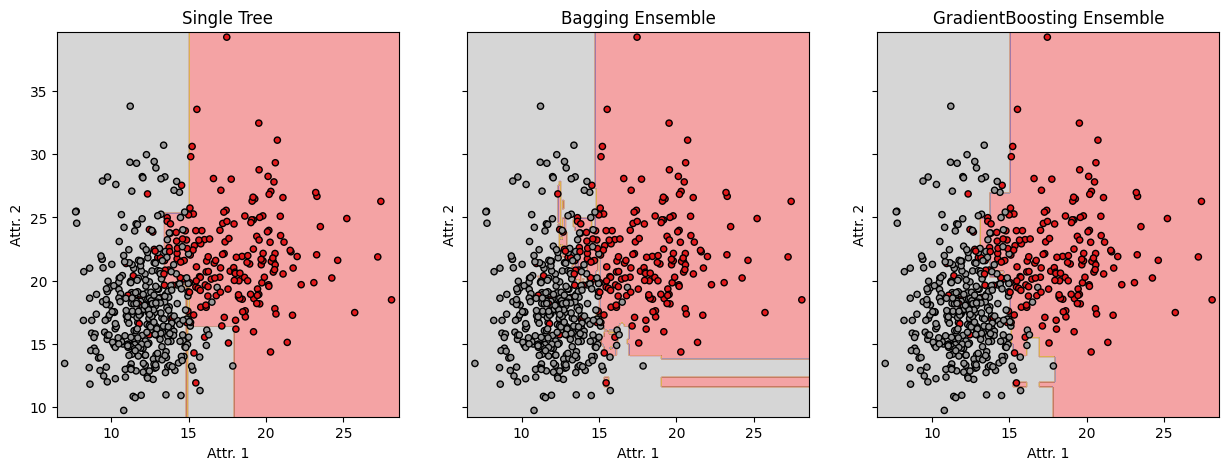

In [15]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15, 5))

Z = pipeline_tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr[0].contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Set1)
axarr[0].scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap=plt.cm.Set1)
axarr[0].set_title('Single Tree')
axarr[0].set_xlabel('Attr. 1')
axarr[0].set_ylabel('Attr. 2')

Z = pipeline_bag.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr[1].contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Set1)
axarr[1].scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap=plt.cm.Set1)
axarr[1].set_title('Bagging Ensemble')
axarr[1].set_xlabel('Attr. 1')
axarr[1].set_ylabel('Attr. 2')

Z = pipeline_gb.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr[2].contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Set1)
axarr[2].scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap=plt.cm.Set1)
axarr[2].set_title('GradientBoosting Ensemble')
axarr[2].set_xlabel('Attr. 1')
axarr[2].set_ylabel('Attr. 2')

plt.show()

We observe that the frontier given by the bagging ensemble is slightly more complicated than that of a single tree. The frontier given by Gradient boosting is similar but more complicated than that of a single tree. 

### Overfitting Problem on a Synthetic Dataset

We show here that gradient boosting can also overfit the training data. For that, we generate first some sinthetic data, and then, train a gradient boosting classifier using regression stumps. We consider a two dimensional problem in which the task is to tell whether or not a point outside the unit radius circle. The data is generated uniformly in the $[-1.5,1.5]^2$ box. 

We generate the synthetic data.

In [16]:
np.random.seed(0)

X = np.random.uniform(-1.25, 1.5, size = ((500, 2)))
y = (np.sqrt(np.sum(X**2, 1)) < 1).astype(int)

We plot the data.

In [17]:
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

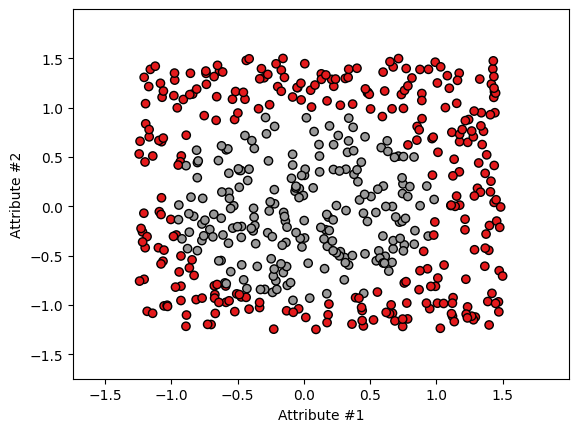

In [18]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, \
    edgecolor='k')
plt.xlabel('Attribute #1')
plt.ylabel('Attribute #2')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

We illustrate again in this classification problem the overfitting issue of gradient boosting. For that, we contaminate again the training labels with noise.

In [22]:
sel = np.random.choice(len(y), int(np.round(len(y) * 0.2)))
y_noisy = y.copy()
y_noisy[ sel ] = ((y_noisy[ sel ] + 1) % 1 == 1).astype(int)

# Gradient Boosting

pipeline_gb = Pipeline([ ('gb', GradientBoostingClassifier(learning_rate = 0.5,\
        n_estimators = 201)) ])

# Next bagging

pipeline_bag = Pipeline([ ('bag', BaggingClassifier(estimator = \
    DecisionTreeClassifier(), n_estimators = 201)) ])

# We fit the classifiers

pipeline_gb.fit(X, y_noisy)
pipeline_bag.fit(X, y_noisy)


Pipeline(steps=[('bag',
                 BaggingClassifier(estimator=DecisionTreeClassifier(),
                                   n_estimators=201))])

We plot the decision boundaries of bagging and gradient boosting.

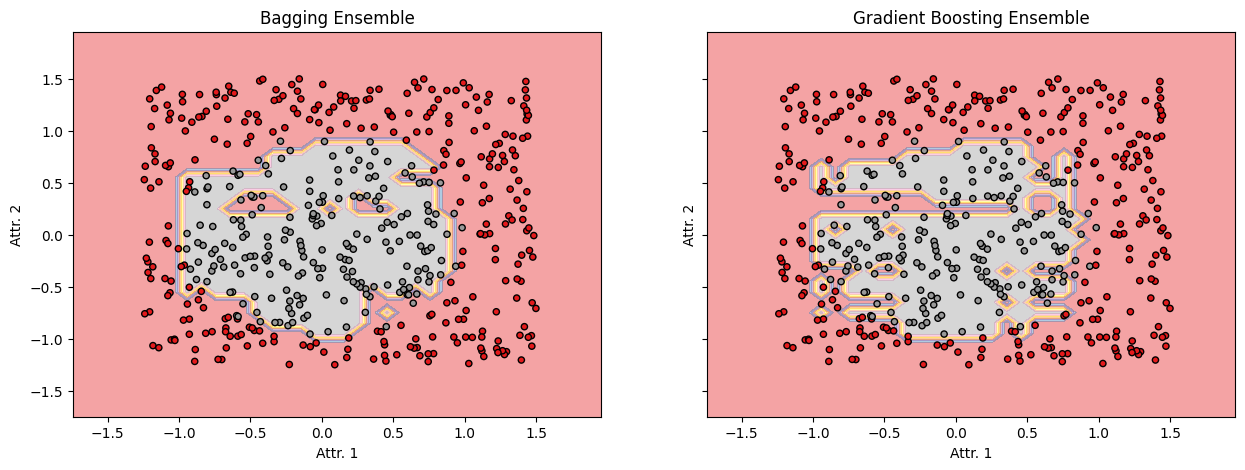

In [23]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15, 5))

Z = pipeline_bag.predict(np.c_[xx.ravel(), yy.ravel()])
Zstump = Z.copy()
Z = Z.reshape(xx.shape)

axarr[0].contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Set1)
axarr[0].scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap=plt.cm.Set1)
axarr[0].set_title('Bagging Ensemble')
axarr[0].set_xlabel('Attr. 1')
axarr[0].set_ylabel('Attr. 2')

Z = pipeline_gb.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr[1].contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Set1)
axarr[1].scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap=plt.cm.Set1)
axarr[1].set_title('Gradient Boosting Ensemble')
axarr[1].set_xlabel('Attr. 1')
axarr[1].set_ylabel('Attr. 2')

plt.show()

Gradient boosting seems to over-fit the noise in the training data more than bagging.